In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import re
import io
import string
from sklearn.metrics import roc_auc_score,roc_curve
from matplotlib import pyplot as plt


In [2]:
raw = pd.read_csv('jigsaw-toxic-comment-train.csv')

In [3]:
clean = []
for elem in raw.comment_text:
  #remove ip address
  elem = re.sub( r'[0-9]+(?:\.[0-9]+){3}','', elem )
  #remove url
  elem = re.sub(r'^https?:\/\/.*[\r\n]*', '', elem)
  #remove tab/newline
  elem = re.sub(r'[\n\t]',' ',elem)
  #remove punctuation
  elem = elem.translate(elem.maketrans("","",string.punctuation))
  #remove multiple space
  elem = re.sub(r'[ ]{2,}',' ',elem)
  clean.append(elem)

In [4]:
train = raw
train.drop("comment_text", axis=1, inplace = True)
train["comment_text"] = clean

In [5]:
train = train.set_index('id')

In [6]:
# train = pd.read_csv('clean_new_train.csv')

In [7]:
train

,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
id,,,,,,,
0000997932d777bf,0,0,0,0,0,0,Explanation Why the edits made under my userna...
000103f0d9cfb60f,0,0,0,0,0,0,Daww He matches this background colour Im seem...
000113f07ec002fd,0,0,0,0,0,0,Hey man Im really not trying to edit war Its j...
0001b41b1c6bb37e,0,0,0,0,0,0,More I cant make any real suggestions on impr...
0001d958c54c6e35,0,0,0,0,0,0,You sir are my hero Any chance you remember wh...
...,...,...,...,...,...,...,...
fff8f64043129fa2,0,0,0,0,0,0,Jerome I see you never got around to this… I’m...
fff9d70fe0722906,0,0,0,0,0,0,Lucky bastard httpwikimediafoundationorgwikiPr...
fffa8a11c4378854,0,0,0,0,0,0,shame on you all You want to speak about gays ...


In [8]:
#I getting this frome stackoverflow  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels 
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

#     plt.figure(figsize=(10, 6))
    plt.figure(figsize=(6, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'lower')
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Random Forest

### For Toxic

In [9]:
y_columns = "toxic"
x_columns= "comment_text"

x = train[x_columns]
y = train[y_columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=300)

In [10]:
TfidfVector = TfidfVectorizer(max_df=0.7,stop_words='english')
x_train = TfidfVector.fit_transform(x_train)
x_test = TfidfVector.transform(x_test)

In [11]:
x_train,y_train

(<178839x291694 sparse matrix of type '<class 'numpy.float64'>'
 	with 4426100 stored elements in Compressed Sparse Row format>, id
 b4f573637302d67b    0
 007db1f1477ea977    0
 a90805ea511f85b5    1
 a11d8fd50297d10a    0
 bdfb5ff62a4179d0    0
                    ..
 130c0ffea46ccc20    0
 289b92d86c0d0000    0
 a170b4d3824ddeba    1
 adf574d93bec0bab    1
 86b2fb88dbfc80fa    0
 Name: toxic, Length: 178839, dtype: int64)

In [12]:
clf = RandomForestClassifier()
clf = clf.fit(x_train, y_train)

C:\Users\13472\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [13]:
y_pred = clf.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))
random_forest_train = confusion_matrix(y_train, y_pred)
random_forest_accuracy = accuracy_score(y_train, y_pred)


[[161714     62]
 [  1064  15999]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    161776
           1       1.00      0.94      0.97     17063

    accuracy                           0.99    178839
   macro avg       0.99      0.97      0.98    178839
weighted avg       0.99      0.99      0.99    178839



In [14]:
y_pred = clf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

random_forest_test = confusion_matrix(y_test, y_pred)
random_forest_accuracy = accuracy_score(y_test, y_pred)

[[40022   367]
 [ 2230  2091]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     40389
           1       0.85      0.48      0.62      4321

    accuracy                           0.94     44710
   macro avg       0.90      0.74      0.79     44710
weighted avg       0.94      0.94      0.93     44710



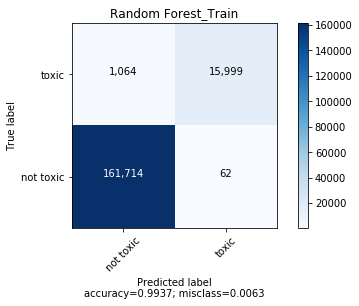

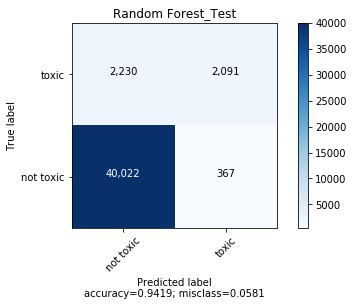

In [15]:
labels = ['not toxic', 'toxic']
plot_confusion_matrix(random_forest_train, labels, title='Random Forest_Train',cmap=None, normalize=False)
plot_confusion_matrix(random_forest_test, labels, title='Random Forest_Test',cmap=None, normalize=False)

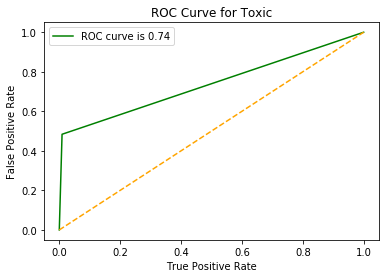

In [16]:

roc_auc=roc_auc_score(y_test, y_pred)
tpr, fpr, a = roc_curve(y_test, y_pred)

plt.plot(tpr, fpr, color='green', label='ROC curve is %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve for Toxic')
plt.legend()

### For severe_toxic

C:\Users\13472\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[177294     10]
 [   260   1275]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177304
           1       0.99      0.83      0.90      1535

    accuracy                           1.00    178839
   macro avg       1.00      0.92      0.95    178839
weighted avg       1.00      1.00      1.00    178839

[[44253    30]
 [  398    29]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     44283
           1       0.49      0.07      0.12       427

    accuracy                           0.99     44710
   macro avg       0.74      0.53      0.56     44710
weighted avg       0.99      0.99      0.99     44710



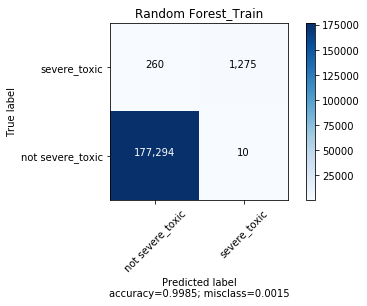

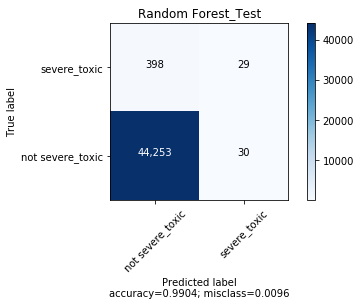

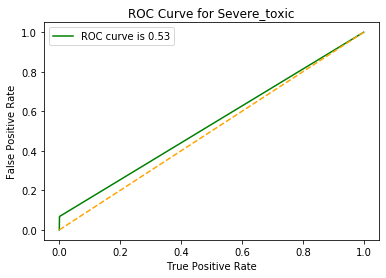

In [17]:
y_columns = "severe_toxic"
x_columns= "comment_text"

x = train[x_columns]
y = train[y_columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=300)

TfidfVector = TfidfVectorizer(max_df=0.7,stop_words='english')
x_train = TfidfVector.fit_transform(x_train)
x_test = TfidfVector.transform(x_test)

clf = RandomForestClassifier()
clf = clf.fit(x_train, y_train)

# scores = cross_val_score(clf, x_train, y_train)
# scores.mean()

y_pred = clf.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

random_forest_train = confusion_matrix(y_train, y_pred)
random_forest_accuracy = accuracy_score(y_train, y_pred)

y_pred = clf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

random_forest_test = confusion_matrix(y_test, y_pred)
random_forest_accuracy = accuracy_score(y_test, y_pred)

labels = ['not severe_toxic', 'severe_toxic']
plot_confusion_matrix(random_forest_train, labels, title='Random Forest_Train',cmap=None, normalize=False)
plot_confusion_matrix(random_forest_test, labels, title='Random Forest_Test',cmap=None, normalize=False)

roc_auc=roc_auc_score(y_test, y_pred)
tpr1, fpr1, a= roc_curve(y_test, y_pred)

plt.plot(tpr1, fpr1, color='green', label='ROC curve is %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve for Severe_toxic')
plt.legend()

### For obscene

C:\Users\13472\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[169120     47]
 [   510   9162]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169167
           1       0.99      0.95      0.97      9672

    accuracy                           1.00    178839
   macro avg       1.00      0.97      0.98    178839
weighted avg       1.00      1.00      1.00    178839

[[42009   233]
 [ 1143  1325]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42242
           1       0.85      0.54      0.66      2468

    accuracy                           0.97     44710
   macro avg       0.91      0.77      0.82     44710
weighted avg       0.97      0.97      0.97     44710



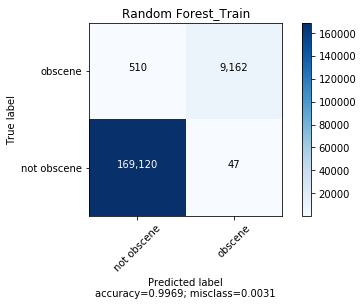

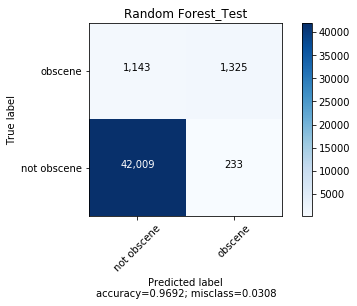

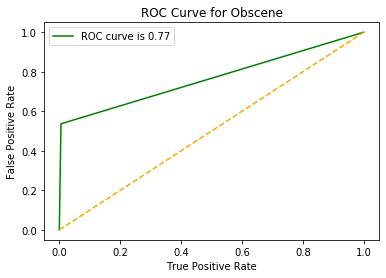

In [18]:
y_columns = "obscene"
x_columns= "comment_text"

x = train[x_columns]
y = train[y_columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=300)

TfidfVector = TfidfVectorizer(max_df=0.7,stop_words='english')
x_train = TfidfVector.fit_transform(x_train)
x_test = TfidfVector.transform(x_test)

clf = RandomForestClassifier()
clf = clf.fit(x_train, y_train)

# scores = cross_val_score(clf, x_train, y_train)
# scores.mean()

y_pred = clf.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

random_forest_train = confusion_matrix(y_train, y_pred)
random_forest_accuracy = accuracy_score(y_train, y_pred)

y_pred = clf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

random_forest_test = confusion_matrix(y_test, y_pred)
random_forest_accuracy = accuracy_score(y_test, y_pred)

labels = ['not obscene', 'obscene']
plot_confusion_matrix(random_forest_train, labels, title='Random Forest_Train',cmap=None, normalize=False)
plot_confusion_matrix(random_forest_test, labels, title='Random Forest_Test',cmap=None, normalize=False)


roc_auc=roc_auc_score(y_test, y_pred)
tpr2, fpr2, a = roc_curve(y_test, y_pred)

plt.plot(tpr2, fpr2, color='green', label='ROC curve is %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve for Obscene')
plt.legend()


### For threat

C:\Users\13472\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[178289      8]
 [   112    430]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178297
           1       0.98      0.79      0.88       542

    accuracy                           1.00    178839
   macro avg       0.99      0.90      0.94    178839
weighted avg       1.00      1.00      1.00    178839

[[44554     9]
 [  144     3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44563
           1       0.25      0.02      0.04       147

    accuracy                           1.00     44710
   macro avg       0.62      0.51      0.52     44710
weighted avg       0.99      1.00      1.00     44710



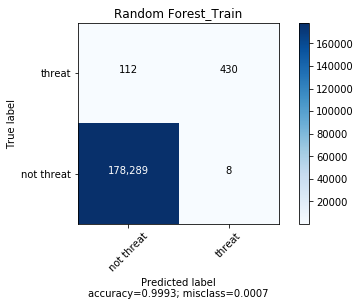

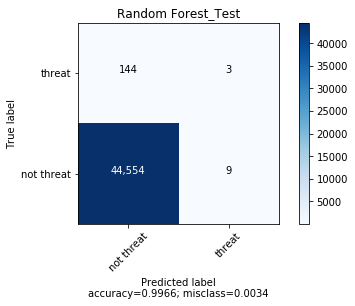

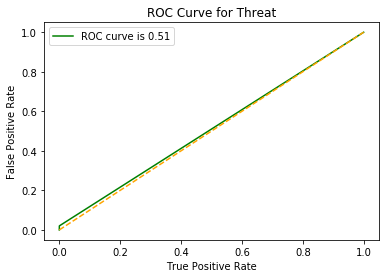

In [19]:
y_columns = "threat"
x_columns= "comment_text"

x = train[x_columns]
y = train[y_columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=300)

TfidfVector = TfidfVectorizer(max_df=0.7,stop_words='english')
x_train = TfidfVector.fit_transform(x_train)
x_test = TfidfVector.transform(x_test)


clf = RandomForestClassifier()
clf = clf.fit(x_train, y_train)

# scores = cross_val_score(clf, x_train, y_train)
# scores.mean()

y_pred = clf.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

random_forest_train = confusion_matrix(y_train, y_pred)
random_forest_accuracy = accuracy_score(y_train, y_pred)

y_pred = clf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

random_forest_test = confusion_matrix(y_test, y_pred)
random_forest_accuracy = accuracy_score(y_test, y_pred)

labels = ['not threat', 'threat']
plot_confusion_matrix(random_forest_train, labels, title='Random Forest_Train',cmap=None, normalize=False)
plot_confusion_matrix(random_forest_test, labels, title='Random Forest_Test',cmap=None, normalize=False)


roc_auc=roc_auc_score(y_test, y_pred)
tpr3, fpr3, a = roc_curve(y_test, y_pred)

plt.plot(tpr3, fpr3, color='green', label='ROC curve is %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve for Threat')
plt.legend()


### For insult

C:\Users\13472\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[169825     65]
 [   604   8345]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169890
           1       0.99      0.93      0.96      8949

    accuracy                           1.00    178839
   macro avg       0.99      0.97      0.98    178839
weighted avg       1.00      1.00      1.00    178839

[[42100   255]
 [ 1456   899]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42355
           1       0.78      0.38      0.51      2355

    accuracy                           0.96     44710
   macro avg       0.87      0.69      0.75     44710
weighted avg       0.96      0.96      0.96     44710



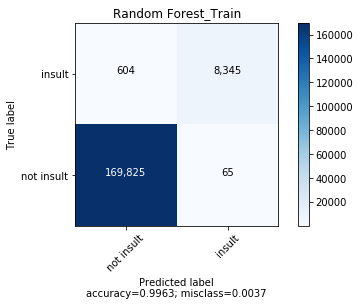

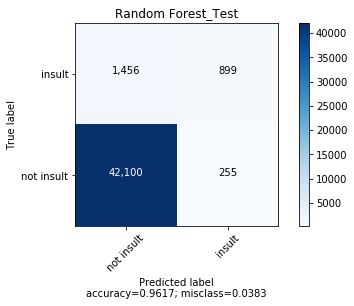

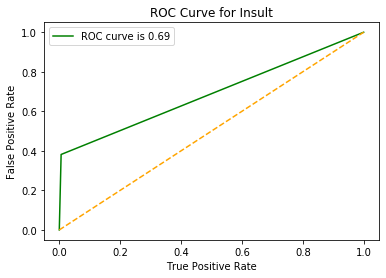

In [20]:
y_columns = "insult"
x_columns= "comment_text"

x = train[x_columns]
y = train[y_columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=300)

TfidfVector = TfidfVectorizer(max_df=0.7,stop_words='english')
x_train = TfidfVector.fit_transform(x_train)
x_test = TfidfVector.transform(x_test)


clf = RandomForestClassifier()
clf = clf.fit(x_train, y_train)

# scores = cross_val_score(clf, x_train, y_train)
# scores.mean()

y_pred = clf.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

random_forest_train = confusion_matrix(y_train, y_pred)
random_forest_accuracy = accuracy_score(y_train, y_pred)

y_pred = clf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

random_forest_test = confusion_matrix(y_test, y_pred)
random_forest_accuracy = accuracy_score(y_test, y_pred)

labels = ['not insult', 'insult']
plot_confusion_matrix(random_forest_train, labels, title='Random Forest_Train',cmap=None, normalize=False)
plot_confusion_matrix(random_forest_test, labels, title='Random Forest_Test',cmap=None, normalize=False)


roc_auc=roc_auc_score(y_test, y_pred)
tpr4, fpr4, thresholds = roc_curve(y_test, y_pred)

plt.plot(tpr4, fpr4, color='green', label='ROC curve is %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve for Insult')
plt.legend()

### For Identity_hate

C:\Users\13472\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[177152      6]
 [   270   1411]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177158
           1       1.00      0.84      0.91      1681

    accuracy                           1.00    178839
   macro avg       1.00      0.92      0.96    178839
weighted avg       1.00      1.00      1.00    178839

[[44259    15]
 [  386    50]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     44274
           1       0.77      0.11      0.20       436

    accuracy                           0.99     44710
   macro avg       0.88      0.56      0.60     44710
weighted avg       0.99      0.99      0.99     44710



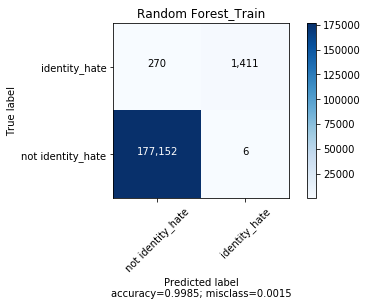

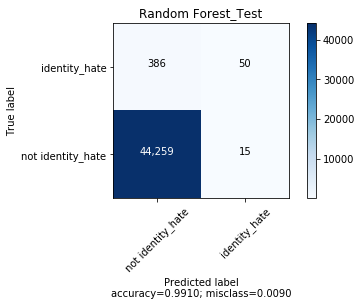

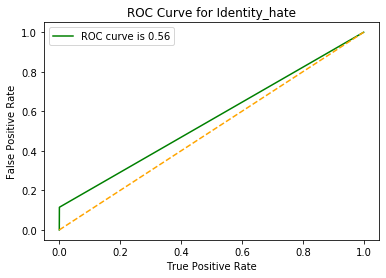

In [21]:
y_columns = "identity_hate"
x_columns= "comment_text"

x = train[x_columns]
y = train[y_columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=300)

TfidfVector = TfidfVectorizer(max_df=0.7,stop_words='english')
x_train = TfidfVector.fit_transform(x_train)
x_test = TfidfVector.transform(x_test)


clf = RandomForestClassifier()
clf = clf.fit(x_train, y_train)

# scores = cross_val_score(clf, x_train, y_train)
# scores.mean()

y_pred = clf.predict(x_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

random_forest_train = confusion_matrix(y_train, y_pred)
random_forest_accuracy = accuracy_score(y_train, y_pred)

y_pred = clf.predict(x_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

random_forest_test = confusion_matrix(y_test, y_pred)
random_forest_accuracy = accuracy_score(y_test, y_pred)

labels = ['not identity_hate', 'identity_hate']
plot_confusion_matrix(random_forest_train, labels, title='Random Forest_Train',cmap=None, normalize=False)
plot_confusion_matrix(random_forest_test, labels, title='Random Forest_Test',cmap=None, normalize=False)

roc_auc=roc_auc_score(y_test, y_pred)
tpr5, fpr5, a = roc_curve(y_test, y_pred)

plt.plot(tpr5, fpr5, color='green', label='ROC curve is %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve for Identity_hate')
plt.legend()


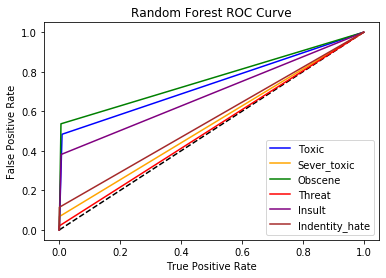

In [22]:
plt.title('Random Forest ROC Curve')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(tpr, fpr, color='blue', label="Toxic")
plt.plot(tpr1, fpr1, color='orange', label="Sever_toxic")
plt.plot(tpr2, fpr2, color='green', label="Obscene")
plt.plot(tpr3, fpr3, color='red', label="Threat")
plt.plot(tpr4, fpr4, color='purple', label="Insult")
plt.plot(tpr5, fpr5, color='brown', label="Indentity_hate")
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend()